# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Final Project - Method - Seq2Seq Attention

**Harvard University**<br/>
**Spring 2020**<br/>
**Group 32**: 

<hr style="height:2pt">

In [3]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)


## <a id='0'>Content</a>

- <a href='#1'>1. Overview</a> 
- <a href='#2'>2. Data</a>
- <a href='#3'>3. Model</a>
- <a href='#4'>4. Conclusion</a>  



## <a id='1'>1. Overview</a>

This method is a seq2seq with attention model that uses code from the following blog post as a basis.

https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

The model is designed to return an abstration of the case opinion that is trained on the headnotes in the dataset. 

## <a id=2>2. Data </a>

Long sequences caused this model to crash during training so the training dataset was cut down to around 5,000 cases that are in the bottom 30% of sequence length.

The text pre-processing is based on the blog listed above and it removes all punctuation and stop words from the case opinions and headnotes.

## <a id=3>3. Model <a/>
    
The model architecture utilizes both bidirectional LSTM layers and LSTM layers. Dropout layers are also utilized to regularize the model. This is a modification from the blog post that did not use bidirectional LSTM layers and that did not use dropout layers.

The optimizer was also changed from rmsprop to adam and the batchsize was experimented with and ultimetly selected as a balance between crashing the kernel and model performance.

## <a id=4>4. Conclusion<a/>

This model was not selected due to low rouge scores as well as poor performance in producing headnotes that appear relevant to a human reader. 

Adding two bidirectional layers in the encoder improved the rouge scores over the blog model and adding dropout layers slowed down the training and generally lead to improved validation accuracy over more epochs.

In [4]:
import json
import lzma
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
from IPython.core.display import display, HTML
import re
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

from attention import AttentionLayer
# tokenizer = RegexpTokenizer('\s+', gaps=True)
import nltk
nltk.download('stopwords')

from rouge import Rouge

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/91354489/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [6]:
# function to process and format text

stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [7]:
# function to read data and apply text processing

def get_cases(state, subset=True, num_cases=100):
    cases = []
    with lzma.open(state + '/data/data.jsonl.xz', 'r') as jsonl_file:
        for i, case in enumerate(jsonl_file):
            c = json.loads(str(case, 'utf-8'))

            date = c['decision_date']
            
            headnotes = c['casebody']['data']['head_matter']
            if headnotes == []:
                continue
            headnotes = text_cleaner(headnotes)
            num_head = len(headnotes)
            
            name = text_cleaner(c['name'])
            docket_number = text_cleaner(c['docket_number'])

            opinions = c['casebody']['data']['opinions']
            if opinions == []:
                continue

            opinions = text_cleaner(opinions[0]['text'])
            body = name + docket_number + opinions
            num_body = len(body)
                
            cases.append({'date':date, 'num_head':num_head, 'head':headnotes, 'num_body':num_body, 'body':body})
            if subset == True:
                if i > num_cases:
                    break
        return pd.DataFrame(cases)

In [5]:
# reading and cleaning case text

df = get_cases('North Carolina', subset=False, num_cases=10)
df['head'] = df['head'].apply(lambda x: '_START_ '+ x + ' _END_')
df.shape

(97586, 5)

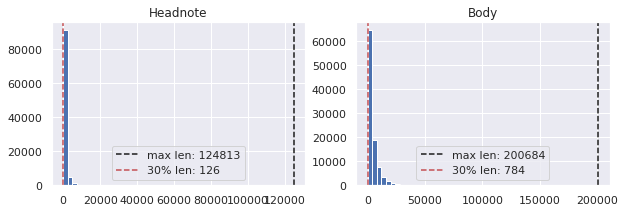

In [6]:
# Finding a threshold to subset the data due to challenges training on cases that
# have a long sequence length.

q = 30
q_head = int(np.percentile(df.num_head,q))
q_body = int(np.percentile(df.num_body,q))

f, ax = plt.subplots(1,2,figsize=[10,3])
ax[0].hist(df.num_head, bins=50)
ax[0].axvline(np.max(df.num_head), label='max len: ' + str(np.max(df.num_head)), color='k', ls='--')
ax[0].axvline(q_head, label=str(q) + '% len: ' + str(q_head), color='r', ls='--')
ax[0].set_title('Headnote')
ax[0].legend()
ax[1].hist(df.num_body, bins=50)
ax[1].axvline(np.max(df.num_body), label='max len: ' + str(np.max(df.num_body)), color='k', ls='--')
ax[1].axvline(q_body, label=str(q) + '% len: ' + str(q_body), color='r', ls='--')
ax[1].legend()
ax[1].set_title('Body')
plt.show()

In [8]:
# Selecting the subset of data for training. Cases with longer sequences caused
# problems with the kernel on Jupyter Hub crashing. The floor is set to try and 
# limit headnotes that are only a couple of words.

max_head = q_head
max_body = q_body

df = df[(df['num_head'] <= q_head) & (df['num_head'] > 20) & 
        (df['num_body'] <= q_body) & (df['num_body'] > 100)]
print(df.shape)
display(df[['num_head']].describe().T)
display(df[['num_body']].describe().T)

# display(df.head())
df.shape

(5525, 5)


,count,mean,std,min,25%,50%,75%,max
num_head,5525.0,62.876561,35.371587,21.0,29.0,50.0,98.0,126.0


,count,mean,std,min,25%,50%,75%,max
num_body,5525.0,278.74009,188.62687,101.0,129.0,192.0,388.0,784.0


(5525, 5)

In [8]:
# df.to_json('df.json')
df = pd.read_json('df.json')

115
22


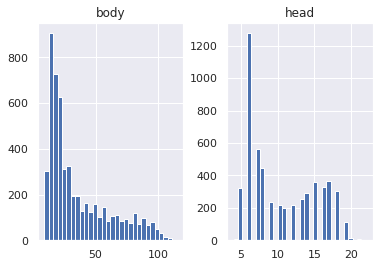

In [9]:
# plotting the word count in headnotes and opinions

text_word_count = []
summary_word_count = []

for i in df['body']:
      text_word_count.append(len(i.split()))

for i in df['head']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'body':text_word_count, 'head':summary_word_count})
max_head = length_df['head'].max()
max_body = length_df['body'].max()
print(max_body)
print(max_head)
length_df.hist(bins = 30)
plt.show()

In [12]:
# setting variables that will be used for inference and scoring

max_len_text = max_body
max_len_summary = max_head

In [13]:
# splitting the validation and training set on a 90/10 split

x_tr, x_val, y_tr, y_val = train_test_split(df['body'], df['head'], test_size=0.05, random_state=42)

In [14]:
# tokenize sequences
x_toke = Tokenizer()
x_toke.fit_on_texts(list(x_tr))
x_tr = x_toke.texts_to_sequences(x_tr)
x_val = x_toke.texts_to_sequences(x_val)

# padding
x_tr = pad_sequences(x_tr, maxlen=max_body, padding='post')
x_val = pad_sequences(x_val, maxlen=max_body, padding='post')

x_voc_size   =  len(x_toke.word_index) + 1

In [15]:
# tokenize sequences
y_toke = Tokenizer()
y_toke.fit_on_texts(list(y_tr))
y_tr = y_toke.texts_to_sequences(y_tr)
y_val = y_toke.texts_to_sequences(y_val)

# padding
y_tr = pad_sequences(y_tr, maxlen=max_head, padding='post')
y_val = pad_sequences(y_val, maxlen=max_head, padding='post')

y_voc_size   =  len(y_toke.word_index) + 1

# Model

In [16]:
# creating the model architecture

from keras import backend as K 
K.clear_session() 
latent_dim = 500 
drop_out = 0.5

# Encoder 
encoder_inputs = Input(shape=(max_body,)) 
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_inputs) 


#LSTM 1 
encoder_lstm1 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True))
encoder_output1, state_h1, state_c1, state_h1_backward, state_c1_backward = encoder_lstm1(enc_emb)
drop1 = Dropout(drop_out)(encoder_output1)

#LSTM 2 
encoder_lstm2 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True))
encoder_output2, state_h2, state_c2, state_h2_backward, state_c2_backward  = encoder_lstm2(drop1) 
drop2 = Dropout(drop_out)(encoder_output2)

#LSTM 3 
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder_lstm3(drop2)

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 115)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 115, 500)     8299000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 115, 1000),  4004000     embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 115, 1000)    0           bidirectional[0][0]              
______________________________________________________________________________________________

In [39]:
# compiling the model and training

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
                  epochs=20, batch_size=128, 
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))
model.save_weights('model_blog_weights_bidirectional_5k.h5')

Train on 5248 samples, validate on 277 samples
Epoch 1/20
5248/5248 [==============================] - 73s 14ms/sample - loss: 3.9186 - val_loss: 2.8273
Epoch 2/20
5248/5248 [==============================] - 57s 11ms/sample - loss: 3.0523 - val_loss: 2.6318
Epoch 3/20
5248/5248 [==============================] - 57s 11ms/sample - loss: 2.8873 - val_loss: 2.5469
Epoch 4/20
5248/5248 [==============================] - 57s 11ms/sample - loss: 2.7634 - val_loss: 2.4576
Epoch 5/20
5248/5248 [==============================] - 57s 11ms/sample - loss: 2.6222 - val_loss: 2.3872
Epoch 6/20
5248/5248 [==============================] - 57s 11ms/sample - loss: 2.4807 - val_loss: 2.3311
Epoch 7/20
5248/5248 [==============================] - 57s 11ms/sample - loss: 2.3543 - val_loss: 2.2904
Epoch 8/20
5248/5248 [==============================] - 57s 11ms/sample - loss: 2.2295 - val_loss: 2.2615
Epoch 9/20
5248/5248 [==============================] - 57s 11ms/sample - loss: 2.1293 - val_loss: 2.2522

In [17]:
model.load_weights('model_blog_weights_bidirectional_5k.h5')

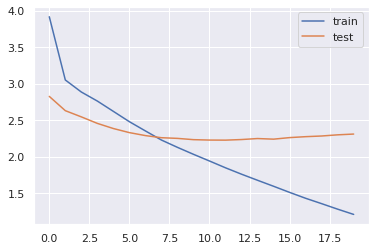

In [43]:
# plotting accuracy over epochs

plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [18]:
# creating dictionaries for prediction and metrics

reverse_target_word_index = y_toke.index_word 
reverse_source_word_index = x_toke.index_word 
target_word_index = y_toke.word_index

In [19]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(inputs = [decoder_inputs] + 
                      [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
                      outputs = [decoder_outputs2] + [state_h2, state_c2])

In [20]:
# setting the max headnote length below based off the plot above that shows this number will 
# capture the majority of headnotes in the training set

max_len_summary = 18

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        ### adding +1 for believed indexing of the word dictionary #######
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) #+ 1
        if sampled_token_index == 0:
            sampled_token = 'pad'
        ##################################################################
        else:
            sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' ' + sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [21]:
# functions to help with metrics and printing text

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [29]:
hypothesis = decode_sequence(x_val[0].reshape(1,max_len_text))
reference = seq2summary(y_val[0])
scores = rouge.get_scores(hypothesis, reference, avg=True)
metrics.append({'f':scores['rouge-1']['f'],
                'p':scores['rouge-1']['p'],
                'r':scores['rouge-1']['r']})

0.2666666617555556

In [31]:
# calculating rouge 1 scores

rouge = Rouge()

metrics = []
for i in range(x_val.shape[0]):
    hypothesis = decode_sequence(x_val[i].reshape(1,max_len_text))
    reference = seq2summary(y_val[i])
    scores = rouge.get_scores(hypothesis, reference, avg=True)
    metrics.append({'f':scores['rouge-1']['f'],
                    'p':scores['rouge-1']['p'],
                    'r':scores['rouge-1']['r']})
metrics = pd.DataFrame(metrics)

In [32]:
# printing the rouge 1 metrics

metrics.mean()

f    0.059458
p    0.045657
r    0.106788
dtype: float64

In [33]:
# printing sample predictions

for i in range(10):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
    print("\n")

Review: fred next friend henry curiam upon controverted issue fact tbe jury responded favor tbe defendant tbe court charge tbe jury challenged several particulars none tbe exceptions regarded sufficient moment work new trial new question law presented tbe assignments error tbe verdict judgment upheld error 
Original summary: fred next friend henry jarman ones wallace white plaintiff appellant summersill defendant appellee 
Predicted summary:  mrs mae chamberlain duke life insurance company tennessee allen plaintiff appellant john hall defendant appellee pad pad


Review: everett mckinley moore paul curiam plenary evidence plaintiff present collision occurred small plaintiff chevrolet collision occurred small using car personal purposes view sufficient evidence support findings collision plaintiff damage proximately caused negligence defendant also negligence small whether testimony small plaintiff witness discloses matter law negligence part proximate cause need decided assuming small 